In [2]:
# =====================================================
# 📌 1. IMPORT LIBRARIES
# =====================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
import joblib

# =====================================================
# 📌 2. LOAD DATASET (Telco Customer Churn)
# =====================================================
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

print(df.head())
print(df.info())
print(df.isnull().sum())


   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

C:\Users\santh\AppData\Local\Temp\ipykernel_21860\2458932208.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


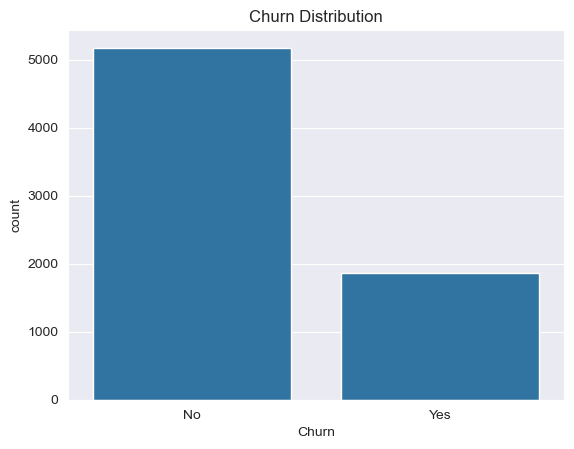

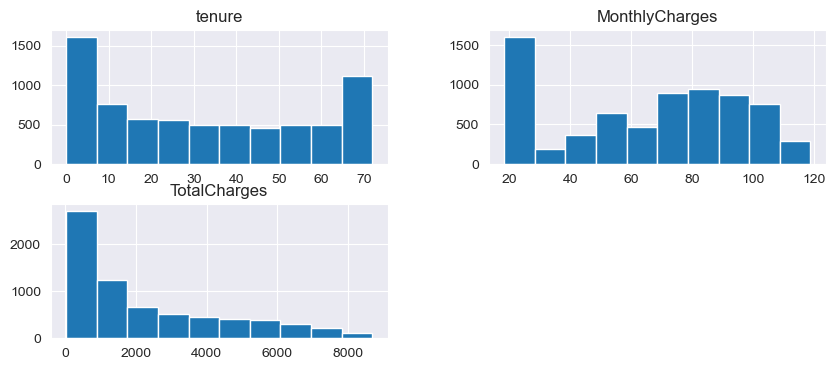

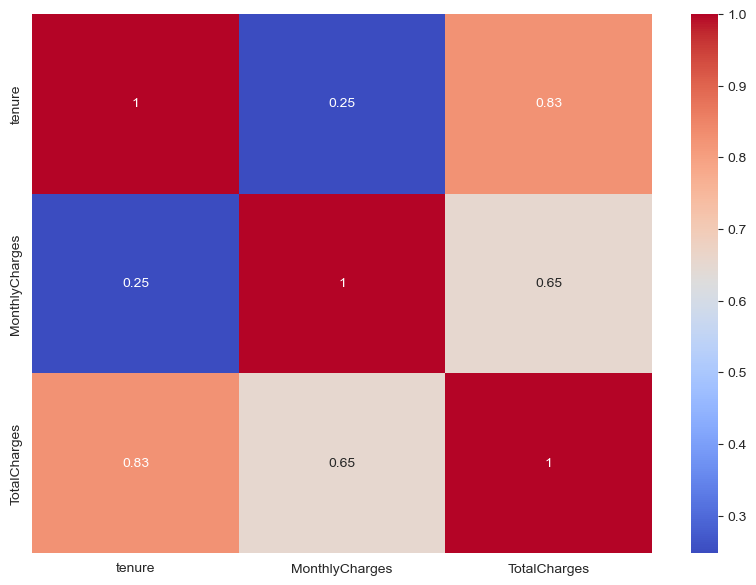

In [3]:
# Replace empty strings in TotalCharges
df["TotalCharges"] = df["TotalCharges"].replace(" ", np.nan)
df["TotalCharges"] = df["TotalCharges"].astype(float)
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

# Churn count
sns.countplot(data=df, x="Churn")
plt.title("Churn Distribution")
plt.show()

# Numerical distribution
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
df[num_cols].hist(figsize=(10, 4))
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm")
plt.show()


In [4]:
# Remove CustomerID
df.drop("customerID", axis=1, inplace=True)

# Convert target
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# Encode categorical
cat_cols = df.select_dtypes("object").columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Split X & y
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fix imbalance using SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [5]:
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_acc = accuracy_score(y_test, lr_pred)
print("Logistic Regression Accuracy:", lr_acc)


Logistic Regression Accuracy: 0.7977288857345636


In [6]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy:", rf_acc)


Random Forest Accuracy: 0.7821149751596878


In [7]:
xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_pred)
print("XGBoost Accuracy:", xgb_acc)


XGBoost Accuracy: 0.7700496806245565


In [8]:
print("\nMODEL PERFORMANCE")
print("Logistic Regression:", lr_acc)
print("Random Forest      :", rf_acc)
print("XGBoost            :", xgb_acc)



MODEL PERFORMANCE
Logistic Regression: 0.7977288857345636
Random Forest      : 0.7821149751596878
XGBoost            : 0.7700496806245565


In [9]:
# Choose best
best_model = xgb   # Change if RF gives better accuracy

joblib.dump(best_model, "best_model.pkl")
joblib.dump(list(X.columns), "model_columns.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Model Saved Successfully!")


Model Saved Successfully!


In [10]:
import streamlit as st
import numpy as np
import joblib

model = joblib.load("best_model.pkl")
columns = joblib.load("model_columns.pkl")
scaler = joblib.load("scaler.pkl")

st.title("📦 Customer Churn Prediction App")

inputs = []

for col in columns:
    val = st.number_input(f"{col}", value=0.0)
    inputs.append(val)

# Convert to array
input_arr = np.array(inputs).reshape(1, -1)
scaled_input = scaler.transform(input_arr)

if st.button("Predict"):
    pred = model.predict(scaled_input)[0]
    if pred == 1:
        st.error("⚠️ Customer is likely to CHURN")
    else:
        st.success("✅ Customer will NOT churn")


2025-12-04 18:16:14.403 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-04 18:16:14.924 
  command:

    streamlit run E:\Anaconda\envs\ml_env\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-12-04 18:16:14.927 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-04 18:16:14.930 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-04 18:16:14.932 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-04 18:16:14.934 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-04 18:16:14.936 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-04 18:16:14.939 Thread 'MainThread': mis